# Chance constraints

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.5"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"


## Import modules

In [159]:
import sys
sys.path.append('../../src')

In [160]:

import pandas 
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.components.result import Result 
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results, min_max
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario, plot_fit
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
from energiapy.aggregation.dtw import dynamic_warping, dynamic_warping_matrix, dynamic_warping_path, IncludeDTW
from energiapy.utils.data_utils import load_results, min_max
from energiapy.fitting.dist import fit
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
import pyomo.environ as pyo
import scipy
from pyomo.environ import Constraint


## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston; CAISO for San Diego
- Natural Gas prices: Henry Hub Price Index for both


**Get Weather data**

**Demand data for San Diego (CAISO for SDGE region) and Houston (ERCOT for COAST region)**

In [161]:
demand_df = pandas.read_excel('../data/Native_Load_2019.xlsx')[['COAST']]
demand_array = demand_df.to_numpy()



In [162]:
data = demand_array
data = min_max(data)
fit_summary = fit(data)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 10.7777] [loc=0.333 scale=0.210]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 20.2434] [loc=0.000 scale=0.333]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 20.2434] [loc=-67108864.000 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.14 sec] [RSS: 7.34855] [loc=0.298 scale=0.174]
[distfit] >INFO> [t         ] [0.84 sec] [RSS: 10.7778] [loc=0.333 scale=0.210]
[distfit] >INFO> [genextreme] [0.19 sec] [RSS: 1.78151] [loc=0.228 scale=0.150]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 2.24972] [loc=-0.007 scale=0.136]
[distfit] >INFO> [lognorm   ] [0.10 sec] [RSS: 1.76447] [loc=-0.088 scale=0.372]
[distfit] >INFO> [beta      ] [0.29 sec] [RSS: 3.01937] [loc=-0.001 scale=1.932]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 24.5207] [loc=0.000 scale=1.000]
[distfit] >INFO> [loggamma  ] [0.10 sec] [RSS: 10.8876] [loc=-52.354 scale=7.412]
[distfit] >INFO> Compute confidence intervals [param

The best fitting distribution is {'name': 'lognorm', 'score': 1.7644713975776731, 'loc': -0.08771839576818041, 'scale': 0.37187286115453144, 'arg': (0.5019778668678803,), 'params': (0.5019778668678803, -0.08771839576818041, 0.37187286115453144), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F593650370>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': 0.07513850564787428, 'CII_max_alpha': 0.7614284543856601}


In [163]:
mean = fit_summary.loc['norm']['loc']
sd = fit_summary.loc['norm']['scale']

In [164]:
from math import erf, sqrt, pi, exp

def norm_constant(p, mu, sigma):
    x = mu + erf(1 / sqrt(2) * p) * sigma * sqrt(2)
    return 1 / (sigma * sqrt(2 * pi)) * exp(-(x - mu)**2 / (2 * sigma**2))

mu = mean  # mean of the normal distribution
sigma = sd  # standard deviation of the normal distribution


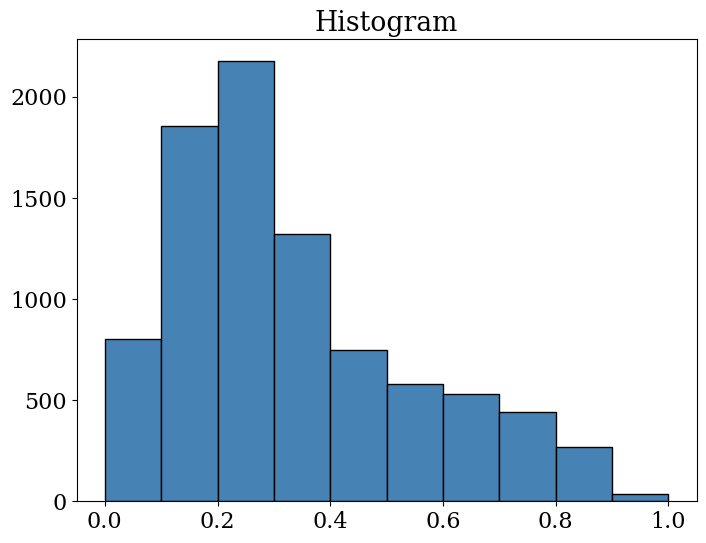

In [165]:
plot_fit.histogram(data = demand_df)

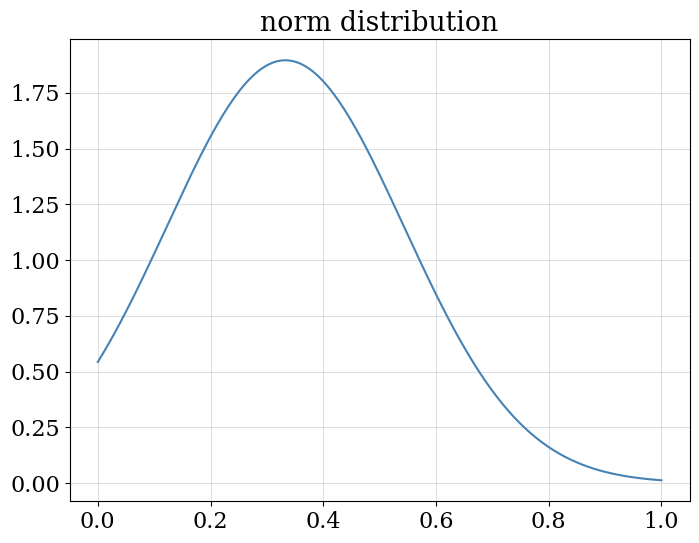

In [166]:
plot_fit.distribution(fit_summary= fit_summary, fit_type= 'norm')

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

In [167]:
scales = TemporalScale(discretization_list=[1])

In [168]:
bigM = 10**6

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold). 

In [169]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated')

$\textbf{Declare processes}$

In [170]:
LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000, store_max = 10000, prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=bigM, label='Wind mill array', basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=bigM, label = 'Solar PV', basis = 'MW')


Processes convert a resource into another through the utilization of resources. 
Essentially, the model is developed as an RTN

In [171]:
houston = Location(name='HO', processes= {WF, PV}, scales=scales, label='Houston', demand_scale_level=0, capacity_scale_level= 0)

scenario = Scenario(name= 'scenario_full', network= houston, scales= scales,  expenditure_scale_level= 0, scheduling_scale_level= 0, 
                    network_scale_level= 0, demand_scale_level= 0, label= 'full_case', demand = {houston: {Power: 150}})


**Minimize cost**

In [172]:

lp = formulate(scenario= scenario, 
                      constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE}, 
                      objective=Objective.COST)


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint demand
objective cost


In [173]:
lp.del_component(lp.constraint_demand)

In [174]:
c_dict = {p: norm_constant(p, mu, sigma) for p in [0.80, 0.90, 0.95, 0.99]}

In [175]:
c_dict

{0.8: 1.3599909086294988,
 0.9: 1.2716499653988471,
 0.95: 1.2297009036373943,
 0.99: 1.1973841893513881}

In [176]:
lp.chance_demand = Constraint(expr = lp.S['HO', 'Power', 0] >= 150*(mu - (1 - 0.9*c_dict[.90])*sigma))

In [177]:
lp.chance_demand.pprint()

chance_demand : Size=1, Index=None, Active=True
    Key  : Lower             : Body          : Upper : Active
    None : 54.48406086764844 : S[HO,Power,0] :  +Inf :   True


In [178]:
results = solve(scenario = scenario, instance= lp, solver= 'gurobi', name= 'results', print_solversteps = True)


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 46 rows, 45 columns and 86 nonzeros
Model fingerprint: 0x12a9a3fa
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+06]
Presolve removed 45 rows and 43 columns
Presolve time: 0.01s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.810508e+00   0.000000e+00      0s
       1    5.4426526e+07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.442652570e+07


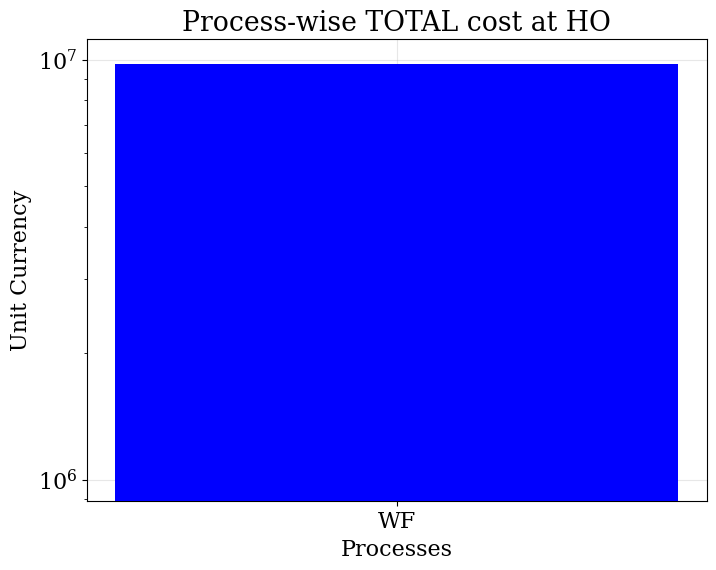

In [157]:
# plot_results.cost(results= results_cost, x = CostX.PROCESS_WISE, y = CostY.CAPEX, location= 'HO', fig_size= (8,6))
# plot_results.cost(results= results_cost, x = CostX.PROCESS_WISE, y = CostY.VOPEX, location= 'HO', fig_size= (8,6))
# plot_results.cost(results= results_cost, x = CostX.PROCESS_WISE, y = CostY.FOPEX, location= 'HO', fig_size= (8,6))
plot_results.cost(results= results, x = CostX.PROCESS_WISE, y = CostY.TOTAL, location= 'HO', fig_size= (8,6))
# plot_results.cost(results= results_demand, x = CostX.PROCESS_WISE, y = CostY.TOTAL, location= 'HO', fig_size= (8,6))


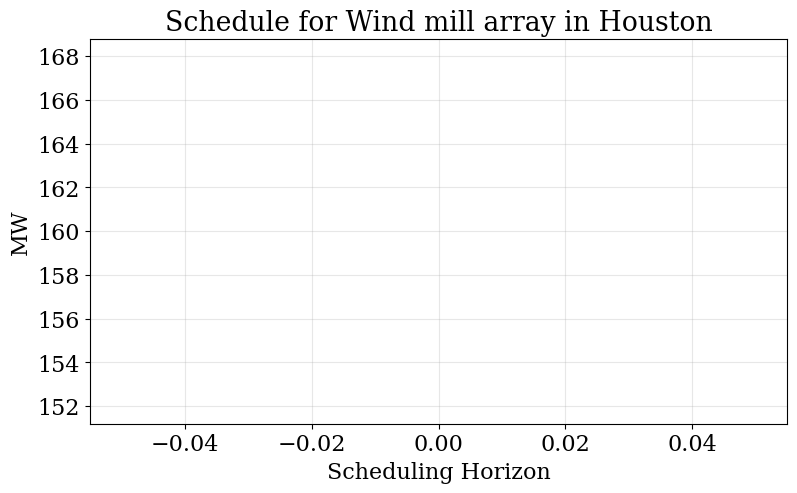

In [158]:
plot_results.schedule(results= results_cost, y_axis= 'P', component= 'WF', location = 'HO', fig_size= (9,5), color = 'steelblue')


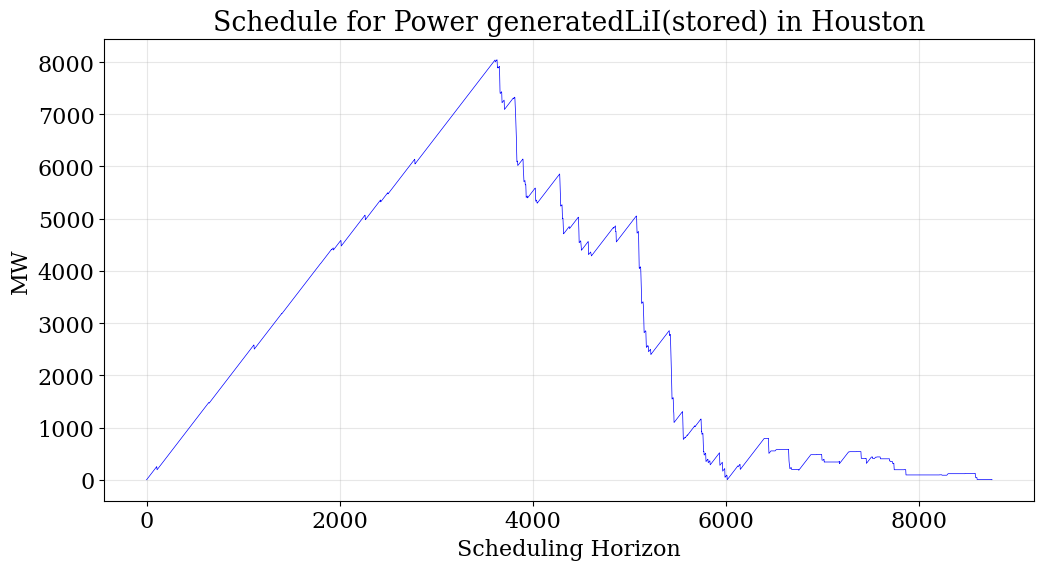

In [23]:
plot_results.schedule(results= results_cost, y_axis= 'Inv', component= 'LiI_Power_stored', location= 'HO')


In [24]:
# results_cost = load_results(filename= 'results_cost.pkl')

In [25]:
from pyomo.contrib.pyros import BoxSet

In [26]:
weather_scaled_df = min_max(weather_df)
demand_scaled_df = min_max(demand_df)


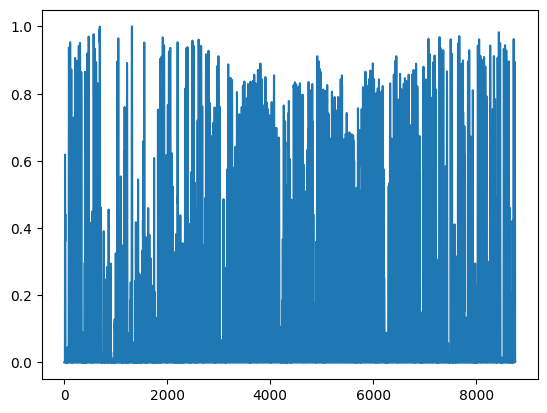

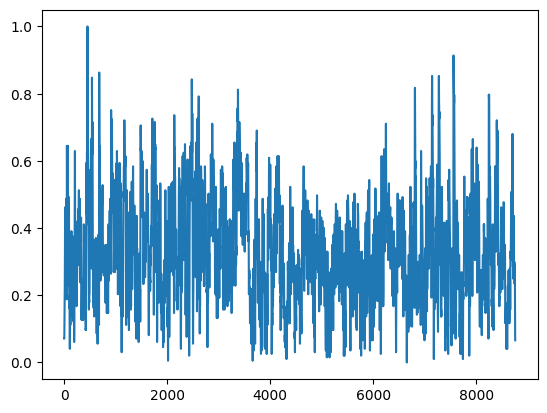

In [27]:
plt.plot(weather_scaled_df['dni'].values)
plt.show()
plt.plot(weather_scaled_df['wind_speed'].values)


In [28]:
demand_scaled_df

,COAST
0,0.140170
1,0.135858
2,0.130485
3,0.128788
4,0.133821
...,...
8755,0.239524
8756,0.219831
8757,0.200798
8758,0.179219


In [29]:
uncertainty_set = BoxSet(bounds= [(0,1), (0,1), (0,1)])

In [34]:
uncertainty_set

In [30]:
uncertain_parameters = []